# Spotify Global Data Insights 2025

## 1. Introduction

This project explores a large Spotify dataset consisting of tracks, albums, and artists, originally sourced and scraped via the Spotify Web API in July 2025.

The goal is to analyze trends in track lengths, explicit content, popular labels, and other characteristics that influence how music is consumed on modern streaming platforms.

By connecting directly to the data stored in PostgreSQL databases, we use SQL for querying and Python (Pandas, Seaborn, Matplotlib, WordCloud) for cleaning, visualization, and extracting insights.

The analysis aims to:

- Showcase real-world SQL and Python data analysis workflows.

- Practice data cleaning and exploration at scale with millions of records.

- Deliver insights and visualizations on modern digital music trends

## 2. Data Overview

The project uses three related datasets stored in PostgreSQL databases.
Each dataset represents a core part of the Spotify ecosystem and covers over hundreds of thousands of songs, albums, and artists.

### Tracks Dataset `spotify_track`

Key fields:

- `durationms` – track length in milliseconds

- `explicit` – whether the track is flagged as explicit

- `trackid`, `name`, `albumid` – identifiers and metadata

Useful for analyzing song length distributions, percentage of explicit music, and providing relevant metadata.

### Albums Dataset `spotify_album`

Key fields:

- `popularity` – album’s Spotify popularity score

- `totaltracks` – number of tracks per album

- `label` – record label responsible for the release

- `releasedate` – release timing for historical trends

Enables exploration of album popularity, label influence, and track count vs. success.

### Artists Dataset `spotify_artist`

Key fields:

- `popularity` – artist’s Spotify popularity score

- `totalfollowers` – number of Spotify followers

- `genres` – genres associated with the artist

- `lastsynctime` – timestamp indicating when the data was last updated

Supports analysis of artist popularity, follower counts, genre trends, and up-to-date snapshots of artist performance.

## 3. Exploratory Data Analysis

### Getting Started

In [207]:
# Import required libraries
import os
import getpass
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
from wordcloud import WordCloud, STOPWORDS
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve database credentials from environment variables
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')        
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')

# Prompt user for password if not set in environment
if not DB_PASS:
    DB_PASS = getpass.getpass('Enter DB password (will not be shown): ')

# Ensure DB_USER is set; raise error if missing
if not DB_USER:
    raise RuntimeError('Please set DB_USER as an environment variable or in a .env file.')

# Create engine to connect to PostgreSQL database
engine1 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_track')

# SQL query to get column names and data types for the 'spotify_track' table
query_columns = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'spotify_track';
'''

# Execute query and load results into a pandas DataFrame
pd.read_sql_query(query_columns, engine1)

,column_name,data_type
0,durationms,integer
1,explicit,boolean
2,tracknumber,integer
3,discnumber,integer
4,isplayable,boolean
5,type,text
6,trackid,text
7,uri,text
8,albumid,text
9,href,text


First, we will set up the environment and database connection for analyzing the `spotify_track` dataset.
It securely loads credentials from a .env file (or prompts for a password if missing), connects to the PostgreSQL database, and queries the schema of the `spotify_track` table.
Inspecting column names and data types ensures we understand the dataset structure before performing any analysis.

### Preview of Track Database

In [208]:
# SQL query to preview the first 5 rows of the spotify_track table
query_head = 'SELECT * FROM spotify_track LIMIT 5;'

# Execute query and load results into a pandas DataFrame
preview_df = pd.read_sql_query(query_head, engine1)

print('Preview of spotify_track table:')
print(preview_df.head())

Preview of spotify_track table:
                  trackid                 albumid  discnumber  durationms  \
0  066w0ykjgvjIJ3ZAoNRcIC  7Fcfb0yt6OH041gPkNF5dd           2      268093   
1  7s1ry2syKjqPz781YDAEww  2kwBoDgmIzk8tCuc0eT9My           1      263995   
2  4uahwprsUDmwPNF7vd6r2X  2kwBoDgmIzk8tCuc0eT9My           1      265925   
3  1bSENgNEsJQbjzVoaYg78O  7legp8gFOT0iY5PTkpAeYC           1      196586   
4  3xMIK15ZQ3DLr6Gr5PTZEx  0qPxDVSSqXVPXNsMS1Vi1B           1      220062   

   explicit                                               href  isplayable  \
0     False  https://api.spotify.com/v1/tracks/066w0ykjgvjI...       False   
1     False  https://api.spotify.com/v1/tracks/7s1ry2syKjqP...       False   
2     False  https://api.spotify.com/v1/tracks/4uahwprsUDmw...       False   
3     False  https://api.spotify.com/v1/tracks/1bSENgNEsJQb...       False   
4     False  https://api.spotify.com/v1/tracks/3xMIK15ZQ3DL...       False   

                       name previewu

By previewing a small subset of rows, we can inspect the structure, verify column names, and check sample values.
Previewing the data early helps confirm that the table loaded correctly and gives an initial sense of the dataset before deeper analysis.

### Track Count

In [209]:
# SQL query to count the total number of rows in the spotify_track table
query_count = 'SELECT COUNT(*) AS total_rows FROM spotify_track'

# Execute query and load the result into a pandas DataFrame
count = pd.read_sql(query_count, engine1)
print(f"The total number of rows: {count['total_rows'][0]}")

The total number of rows: 2128954


Viewing the dataset size helps us understand the scope of analysis, anticipate performance considerations, and plan any data cleaning or sampling steps.

### Checking for Missing and Duplicate Values

In [210]:
# SQL query to select tracks with durations between 0 ms and 900,000 ms (15 minutes)
query_duration = '''
SELECT trackid, name, durationms 
FROM spotify_track 
WHERE durationms > 0
    AND durationms <= 900000
'''

# Execute query and load results into a pandas DataFrame
duration = pd.read_sql_query(query_duration, engine1)

# Check for missing values in each column
print('Missing values per column:\n', duration.isnull().sum())

# Check for duplicate track entries based on trackid
print(f"\nDuplicate rows present: {duration.duplicated(subset=['trackid']).sum()}")


Missing values per column:
 trackid       0
name          0
durationms    0
dtype: int64

Duplicate rows present: 0


We can filter the `spotify_track` dataset to include only tracks with durations between 0 milliseconds and 15 minutes.
While the dataset contains some unusually long tracks, restricting the range to 15 minutes focuses the analysis on typical listener experiences, where most songs fall within a standard duration.
The cell also checks for missing values and duplicate tracks, ensuring that subsequent analyses are accurate and representative of normal listening patterns. We see that there are no values that are missing or duplicated and the attributes are the correct types for our purpose.

### Track Duration Distribution

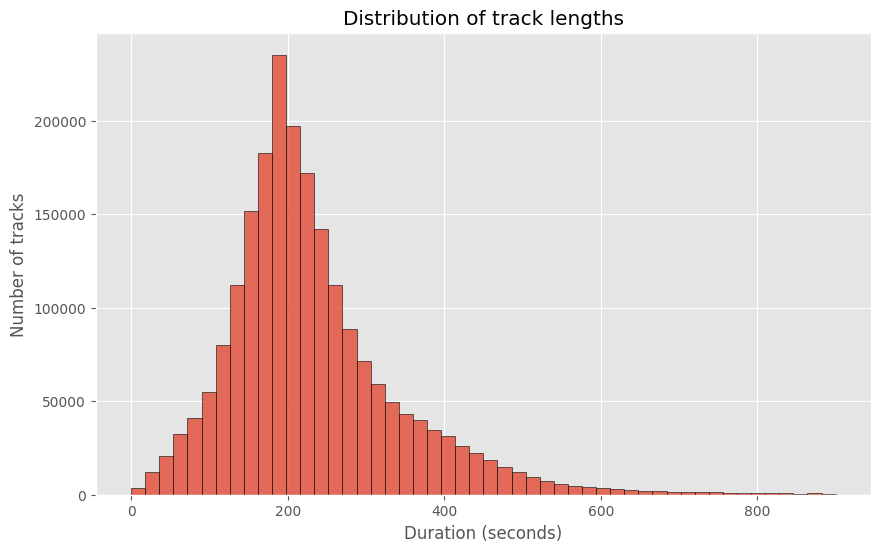

In [211]:
# Convert track duration from milliseconds to seconds for easier interpretation
duration['duration_sec'] = (duration['durationms'] / 1000).astype(int)
duration['duration_sec'].head()

plt.style.use('ggplot')

# Plot a histogram to visualize the distribution of track lengths
plt.figure(figsize=(10,6))
plt.hist(duration['duration_sec'], bins=50, edgecolor='k', alpha=0.8)
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of tracks')
plt.title('Distribution of track lengths')
plt.show()

Converting the track durations from milliseconds to seconds makes the values more intuitive for visualization.
A histogram is then plotted to show the distribution of track lengths in the dataset.
The plot reveals that most tracks are around 200 seconds (approximately 3–4 minutes), highlighting typical song durations and listener patterns, while still focusing on the usual range under 15 minutes.

### Percentage of Explicit Tracks

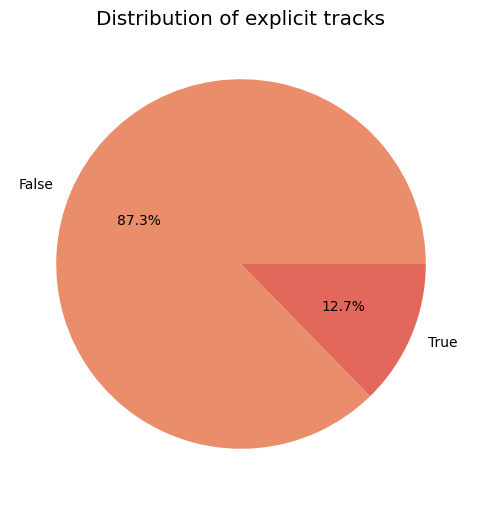

In [212]:
# SQL query to retrieve the 'explicit' column from spotify_track
query_explicit = 'SELECT explicit FROM spotify_track'

# Execute query and load results into a pandas DataFrame
explicit = pd.read_sql_query(query_explicit, engine1)

# Group by explicit flag to count how many tracks are explicit vs. non-explicit
explicit_grp = explicit.groupby('explicit').size()

# Plot a pie chart showing the distribution of explicit tracks
plt.figure(figsize=(10,6))
plt.pie(
    explicit_grp,
    labels=explicit_grp.index,
    autopct='%1.1f%%',                    # Display percentages with 1 decimal place
    colors=sns.color_palette('flare')      
)
plt.title('Distribution of explicit tracks')
plt.show()

By grouping and counting each category, we find that the majority of tracks are non-explicit (87.3%).
The pie chart provides a clear and intuitive view of the dataset’s content, helping understand the prevalence of explicit content in typical tracks.

### Common Words in Track Names

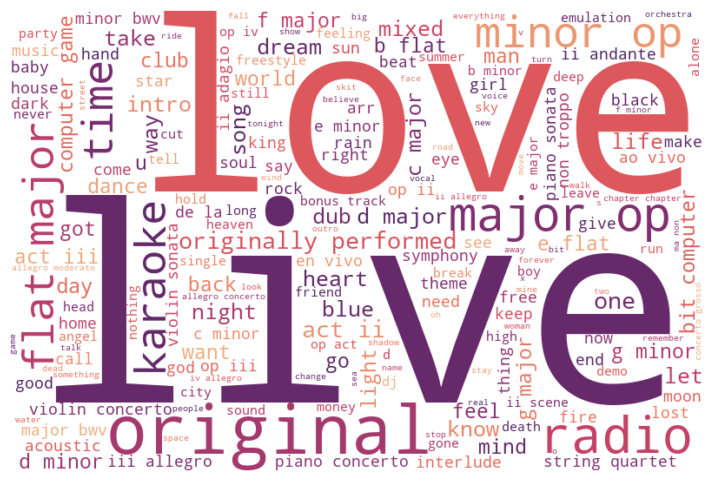

In [213]:
# SQL query to retrieve track names
query_names = 'SELECT name FROM spotify_track'

# Execute query and load results into a pandas DataFrame
names = pd.read_sql_query(query_names, engine1)

# Combine all track names into a single lowercase string
text = ' '.join(names['name']).lower()

# Define additional stopwords to exclude common non-informative words found in song names
more_stopwords = ['instrumental', 'feat', 'remix', 'remaster', 'remastered',
                  'version', 'mix', 'edit', 'extended', 'kapitel']

# Combine default STOPWORDS from WordCloud with custom stopwords
all_stopwords = list(STOPWORDS) + more_stopwords

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=532, 
    background_color='white', 
    colormap='flare', 
    stopwords=all_stopwords
).generate(text)

# Display the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Using a word cloud, we can get an intuitive view of recurring terms in song titles. For clearer representation, we can set all the words found to lowercase for uniformity and remove a some common non-informative words (e.g., "feat", "remix") to highlight meaningful patterns in the dataset.
This is helpful for analyzing trends in naming conventions and popular descriptors. Love appears to be the dominant topic in songs.

### Preview of Album Database

In [214]:
# Create engine to connect to the 'spotify_album' database
engine2 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_album')

# SQL query to retrieve column names and data types for the spotify_album table
query_columns = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'spotify_album';
'''

# Execute query and display table schema
pd.read_sql_query(query_columns, engine2)

,column_name,data_type
0,popularity,integer
1,totaltracks,integer
2,albumtype,text
3,name,text
4,releasedate,text
5,releasedateprecision,text
6,type,text
7,uri,text
8,label,text
9,albumid,text


The attribute `popularity` would some valuable insights. We can explore the relationship between album popularity and track count. Since this database also considers a single as a type of album, we can filter out entries with any `albumtype` other than 'album' for clearer analysis.

In [215]:
# SQL query to select all rows from spotify_album where the album type is 'album'
query_album = '''
SELECT *
FROM spotify_album 
WHERE albumtype='album' 
'''

# Execute query and load results into a pandas DataFrame
albums = pd.read_sql_query(query_album, engine2)

# Display the first few rows of the albums DataFrame
print(albums.head())

                  albumid albumgroup albumtype                      name  \
0  4goBfD1y92lRNsftSKeEsF      album     album                   Quitter   
1  2I0dFovhOqkE4CIY664OW3      album     album            Conscious Self   
2  0tUNlUVBHtya0RTVv4Gd6e      album     album         Subject to Change   
3  6uwykcDF2myUmu7gKIWfsT      album     album      Metal Rain 1989-1993   
4  2zMhbSRZ2A703RF0xeZEhs      album     album  The Viper Club Medic Men   

  releasedate releasedateprecision  totaltracks   type  \
0  2024-02-09                  day           11  album   
1  2023-07-04                  day            8  album   
2  2021-11-12                  day           11  album   
3  2018-11-16                  day           11  album   
4  2018-10-01                  day           11  album   

                                    uri                          label  \
0  spotify:album:4goBfD1y92lRNsftSKeEsF           Nettwerk Music Group   
1  spotify:album:2I0dFovhOqkE4CIY664OW3       

### Checking for Missing and Duplicate Values

In [216]:
# Check for missing values in each column of the albums DataFrame
print('Missing values per column:\n', albums.isnull().sum())

# Check for duplicate albums based on the 'albumid' column
print(f"\nDuplicate rows present: {albums.duplicated(subset=['albumid']).sum()}")

Missing values per column:
 albumid                 0
albumgroup              0
albumtype               0
name                    0
releasedate             0
releasedateprecision    0
totaltracks             0
type                    0
uri                     0
label                   0
popularity              0
artistid                0
dtype: int64

Duplicate rows present: 641


Inspecting the `albums` DataFrame allows us to identify any data quality issues.
By checking each column for missing values and duplicate rows, we can ensure that there are no missing or duplicate entries. This is an essential step before performing analysis, helping maintain accurate insights and visualizations.

### Album Popularity Distribution

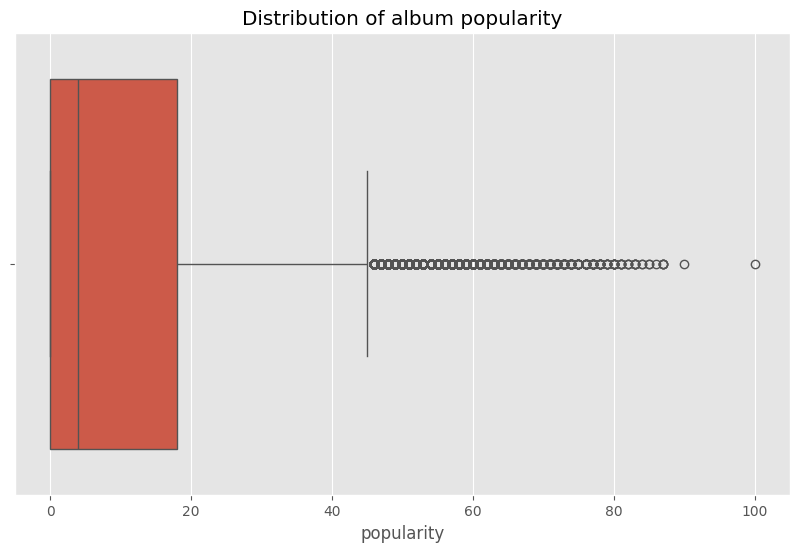

In [217]:
# Plot a boxplot to visualize the distribution of album popularity
plt.figure(figsize=(10,6))
sns.boxplot(x=albums['popularity'])
plt.title('Distribution of album popularity')
plt.show()

This boxplot visualizes the distribution of album popularity (0 - 100).
It highlights the median, quartiles, and potential outliers in popularity scores, helping to understand how album popularity varies across the dataset. We can see that the majority of albums fall under 20/100 popularity and that the number of albums start to get fewer as we get into higher popularity numbers.

### Preview of Artist Database

In [218]:
# Create engine to connect to the 'spotify_artist' database
engine3 = create_engine(f'postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/spotify_artist')

# SQL query to retrieve column names and data types for the spotify_artist table
query_columns = '''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_name = 'spotify_artist';
'''

# Execute query and display table schema
pd.read_sql_query(query_columns, engine3)

,column_name,data_type
0,popularity,integer
1,totalfollowers,integer
2,lastsynctime,timestamp without time zone
3,id,text
4,href,text
5,genres,text
6,uri,text
7,name,text
8,type,text


This dataset could be useful for planning analyses on attributes such as followers, genres, and popularity.

In [219]:
# SQL query to select all rows from the spotify_artist table
query_artist = 'SELECT * FROM spotify_artist'

# Execute query and load results into a pandas DataFrame
artists = pd.read_sql_query(query_artist, engine3)

# Display the first few rows of the artists DataFrame
print(artists.head())

                       id              name  popularity    type  \
0  1cP3VgqGdBT2u1LR6l0nxC      DJ Prezzplay          31  artist   
1  7rulB34zQMrJ5lHoluIDiE  Azamat Abdualiev           0  artist   
2  3frL72H7DIaeoJVBfFpasc          Tonystar           0  artist   
3  1tPjILOuTuIsdLuiuJyDPF  Патимат Кагирова           5  artist   
4  3fuAKA2ES7VqDflASVs6nU       Kts Lil Art           0  artist   

                                     uri  totalfollowers  \
0  spotify:artist:1cP3VgqGdBT2u1LR6l0nxC            1121   
1  spotify:artist:7rulB34zQMrJ5lHoluIDiE               0   
2  spotify:artist:3frL72H7DIaeoJVBfFpasc             100   
3  spotify:artist:1tPjILOuTuIsdLuiuJyDPF             312   
4  spotify:artist:3fuAKA2ES7VqDflASVs6nU               0   

                                                href genres  \
0  https://api.spotify.com/v1/artists/1cP3VgqGdBT...          
1  https://api.spotify.com/v1/artists/7rulB34zQMr...          
2  https://api.spotify.com/v1/artists/3frL72H7D

### Merging Dataframes

In [220]:
# Rename columns for clarity and consistency
artists = artists.rename(columns={'id':'artistid', 'name':'artistname'})

# Create a smaller DataFrame with only artist ID and artist name for merging
artistid = artists[['artistid', 'artistname']].copy()

# Merge albums DataFrame with artist names using artistid as the key
albums_merged = pd.merge(albums, artistid, on='artistid', how='inner')

# Display the first few rows of the merged DataFrame
print(albums_merged.head())

# Print the total number of values (cells) in the merged DataFrame
print(f"\nNumber of rows: {albums_merged.size}")

                  albumid albumgroup albumtype                      name  \
0  4goBfD1y92lRNsftSKeEsF      album     album                   Quitter   
1  2I0dFovhOqkE4CIY664OW3      album     album            Conscious Self   
2  0tUNlUVBHtya0RTVv4Gd6e      album     album         Subject to Change   
3  6uwykcDF2myUmu7gKIWfsT      album     album      Metal Rain 1989-1993   
4  2zMhbSRZ2A703RF0xeZEhs      album     album  The Viper Club Medic Men   

  releasedate releasedateprecision  totaltracks   type  \
0  2024-02-09                  day           11  album   
1  2023-07-04                  day            8  album   
2  2021-11-12                  day           11  album   
3  2018-11-16                  day           11  album   
4  2018-10-01                  day           11  album   

                                    uri                          label  \
0  spotify:album:4goBfD1y92lRNsftSKeEsF           Nettwerk Music Group   
1  spotify:album:2I0dFovhOqkE4CIY664OW3       

Renaming `id` to `artistid` and `name` to `artistname` helps prevent confusion when joining with other tables such as albums or tracks. This cell merges album-level data with artist names to create a comprehensive dataset combining album and artist information.
The merge uses `artistid` as the key to ensure accurate alignment.
The resulting `albums_merged` DataFrame can now be used for analyses allowing easy identification of the artist associated with the album.

### Relationship Between Total Tracks and Popularity

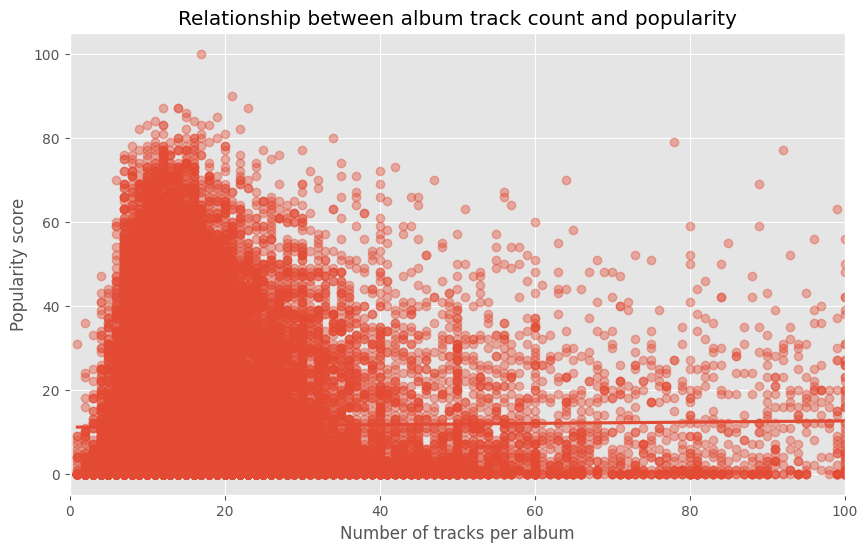

In [221]:
# Plot the relationship between total tracks per album and popularity
plt.figure(figsize=(10,6))

# Scatter plot with regression line; set transparency for better visibility
sns.regplot(
    data=albums_merged,
    x='totaltracks',
    y='popularity',
    scatter_kws={'alpha':0.4}
)

# Limit x-axis to 0–100 tracks for clarity
plt.xlim(0,100)
plt.xlabel('Number of tracks per album')
plt.ylabel('Popularity score')
plt.title('Relationship between album track count and popularity')
plt.show()

This scatter plot explores the relationship between the number of tracks on an album and its popularity score.
Limiting the x-axis to 0–100 tracks focuses on the typical album range, while transparency improves visibility of overlapping points.
This visualization helps determine whether albums with more tracks tend to be more popular, providing insights for artists and record labels when planning album releases.

In [222]:
# Calculate and print the average number of tracks per album
average_tracks = int(np.mean(albums_merged['totaltracks']))
print(f"Average number of tracks per album: {average_tracks}")

Average number of tracks per album: 16


Calculating the average album length provides context for other analyses and helps identify what constitutes a standard album in this dataset.

### Top Labels by Average Album Popularity

In [223]:
# Group albums by label, calculate average popularity per label
top_labels = (
    albums.groupby('label', as_index=False)
          .agg(avg_popularity=('popularity', 'mean'))
          .sort_values(by='avg_popularity', ascending=False)  # Sort descending to find top labels
          .head(10)  # Keep only top 10 labels
)

# Display the top 10 labels by average album popularity
print(top_labels.to_string(index=False))

                                       label  avg_popularity
                       2024 Double P Records            90.0
                    Chappell Roan PS/ Island            87.0
      Top Dawg Entertainment/Capitol Records            81.5
                                  Syco Music            78.8
              Universal Music Latino / Rimas            78.0
              Warner Music Nashville/Elektra            77.0
                                        2018            76.0
Amaru Entertainment, Inc./Interscope Records            76.0
                      OVO / Republic Records            76.0
                             Red Clay Strays            75.0


We identify the top 10 record labels based on the average popularity of their albums.
Grouping by label and calculating the mean popularity highlights which labels consistently release popular albums.

## 4. Key Insights and Recommendations

- **Tracks and Listening Patterns:** Most tracks are under 200 seconds, aligning with typical listener preferences. A small portion of tracks exceed 15 minutes, but the majority of music consumed falls within a standard duration range.

- **Explicit Content:** Approximately 12.7% of tracks are explicit, while 87.3% are non-explicit. This information could guide parental advisory recommendations and playlist curation.

- **Track Name Trends:** Word cloud analysis reveals frequently used terms in track names, providing insight into common themes such as love and keywords that may influence listener engagement.

- **Albums and Artists:** Regression analysis indicates the relationship between total tracks and album popularity, revealing the majority of popular albums are under 20 songs. This is one insight that allows artists and labels to plan album composition strategically.

- **Record Labels:** The top-performing labels based on average album popularity highlight industry leaders and can inform decisions for collaboration, marketing, or talent scouting.

**Recommendation:** Music analysts, record labels, and artists can use these insights to optimize album composition, marketing strategies, and playlist curation, focusing on what resonates most with listeners.